In [6]:
import numpy as np
from skimage import io
from skimage.filters.thresholding import threshold_otsu, threshold_li, threshold_minimum, threshold_multiotsu, threshold_mean
from skimage.morphology import binary_closing, binary_opening, binary_dilation, binary_erosion
from skimage.draw import line, disk, circle_perimeter
from skimage.segmentation import slic
from skimage.segmentation import watershed
from skimage import exposure

from scipy import ndimage
from scipy import sparse
import matplotlib.pyplot as plt
import os
import pickle
import math
from numba import jit
import pandas as pd
import networkx as nx

from timeit import default_timer as timer

from skimage import img_as_ubyte, img_as_uint
import skimage.io as io
from skimage.filters import gaussian
from skimage.feature import peak_local_max

In [2]:
def get_well_locations(folder, well):
    '''
    This function extracts the locations of the well from the excel file.
    '''
    # Import Well locations.xlsx as pandas dataframe and extract the locations
    well_locs_df = pd.read_excel( os.path.join(folder, 'Well locations.xlsx'), index_col=0 )
    xc_well = int(well_locs_df['xc'][well])
    yc_well = int(well_locs_df['yc'][well])
    diameter_well = int(well_locs_df['diameter'][well])
    
    # Raise error if the information is not complete:
    if np.any( np.isnan([xc_well, yc_well, diameter_well]) ):
        raise NameError('The well locations are incomplete. Please update the excel file "Well locations.xlsx"')
    
    return xc_well, yc_well, diameter_well

In [3]:
def get_image(folder, well, xc_well, yc_well, diameter_well):
    '''
    This function reads the (stitched) image in folder specified by 'well'.
    It excludes all pixels of the image outside the circle with center (xc_well, yc_well) and diameter diameter_well.
    '''
    # Read the image:
    img = io.imread( os.path.join( folder, well+'_fused.tif') )
    # Create new black image with the same size:
    new_img = np.zeros(img.shape)
    # Fill the new image with the input image inside the well
    rr, cc = disk((yc_well, xc_well), int(diameter_well / 2))
    new_img[rr,cc,:] = img[rr,cc,:]
    return new_img

In [4]:
def find_nuclei_com(img, N):
    '''
    Function finds the center of mass (COM) of nuclei.
    Input: img = a grayscale image of DAPI channel, N = size of structuring element used for opening the image.
    Output: com = array with centers of mass, lbl = labels of objects.
    '''

    # Apply Otsu thresholding
    threshold = threshold_otsu(img)
    binary = img > threshold

    # Open the image with a N x N structuring element and label result
    opened = binary_opening(binary, selem=np.ones([N,N]))
    lbl, n_obj = ndimage.label(opened)

    # find center of mass of labels
    com_list = ndimage.measurements.center_of_mass(opened, lbl, np.arange(1,n_obj+1))
    
    # store the coms in a numpy array (is compatible with numba)
    com = np.zeros((len(com_list), 3))
    for i in range(len(com)):
        com[i,:] = [ int(i+1), com_list[i][0], com_list[i][1] ]
    
    return com, lbl

In [5]:
def distance_transform_watershed(th, connectivity=np.ones((3,3)), sigma=1, min_distance=10):
    '''
    This function segments all cells in a mask with a distance transform watershed.
    Th is a thresholded (binary) image.
    Sigma is the sigma used for smoothing the distance transform.
    Min_distance is the minimal distance between two cell centers in pixels.
    '''
    dist = ndimage.distance_transform_edt(th)
    dist_smooth = gaussian(dist, sigma=1)

    local_maxi = peak_local_max(dist_smooth, threshold_abs=0, min_distance=min_distance, indices=False)

    markers = ndimage.label(local_maxi)[0]
    
    connectivity = np.ones((3,3))
    labels = watershed(dist_smooth, markers, connectivity=connectivity, mask=th, watershed_line=True)
    
    return labels, markers

In [6]:
def make_markers(com, N, M):
    '''
    Function loops over the locations of the centers of mass of nuclei.
    It outputs an NxM image markers with white pixels on the COM locations.
    '''
    markers = np.zeros((N, M))
    for i,x,y in com:
        markers[int(x)-1, int(y)-1] = i
    
    return markers

In [7]:
def seeded_watershed(img, markers):
    '''
    Function labels individual cells in MEMBRITE channel with the seeded watershed algorithm.
    It first performs a histogram equalization and minimum thresholding.
    
    Input: 
        img: 2D image of membrite channel.
        makers: image of same dimensions as img with seeds.
    Output: labeled image.
    '''
    #img_eq = exposure.equalize_hist(img)
    img_eq = img
    threshold = threshold_mean(img_eq)
    binary = img_eq > threshold
    wts = watershed(binary, markers=markers, mask=binary, watershed_line=False)
    
    return wts

In [14]:
@jit(nopython=True) # compile to C++ for faster performance
def find_network(wts, connectivity=8):
    '''
    Function finds which cells are connected to each other.
    
    Input:
        com = a list of tuples indicating the locations of the centers of mass of nuclei (row, colum).
        wts = watershed-labeled MEMBRITE image.
    
    Output:
        network = a dictionary with the cell number as key and a list as value.
        The first item in value is a tuple indicating the center of mass of the cell's nucleus (row, column).
        The other items in value are the cell numbers of the cells connected to the key cell.  
    '''
    
    # Define structuring element:
    selem = np.ones((2,2))
    if connectivity == 4:
        selem[0,0] = 0
    
    # Initialize network dict with COM locations:
    N,M = wts.shape
    num_cells = np.max(wts)
    network = np.zeros((num_cells, num_cells))
        
    # Loop through the pixels in the image:
    c = 0
    for y in np.arange(1,N):
        for x in np.arange(1,M):
            
            # Get neighborhood (2x2 structuring element) and center pixel
            nbh = wts[y-1:y+1, x-1:x+1]
            prod = selem * nbh
            center = int(prod[1,1])

            if center > 0: # if the center pixel belongs to an object

                north = int(prod[0,1]) # pixel above center pixel
                west = int(prod[1,0])  # pixel left of center pixel
                northwest = int(prod[0,0])

                if north > 0 and center != north:
                    network[center-1, north-1] = 1 # center is connected to the object above it
                    network[north-1, center-1] = 1                       

                if west > 0 and center != west:
                    network[center-1, west-1] = 1 # center is connected to the object left of it
                    network[west-1, center-1] = 1
                    
                if northwest > 0 and center != west:
                    network[center-1, northwest-1] = 1 # center is connected to the object left above of it
                    network[northwest-1, northwest-1] = 1
                    
    return network

In [9]:
def matrix_to_graph(matrix, com):
    '''
    Function converts the network matrix to a dictionary
    Input:
        matrix: a sparse matrix indicating the network
        com: numpy array with locations of centers of mass
    Output: dictionary with network
    '''
    G = nx.Graph()
    
    for row in com:
        i = int(row[0])
        com_pos = tuple(row[1:])
        G.add_node(i, pos=com_pos)
    
    i_array, j_array = matrix.nonzero()
    for i,j in zip(i_array, j_array):
        if (i+1,j+1) not in G.edges:
            G.add_edge(i+1, j+1)
                
    return G

In [10]:
def list_nodes_on_edge(wts, xc_well, yc_well, diameter_well):
    '''
    This function takes as input a network dictionary and the corresponding
    watershed-segmented image.
    It then makes a list of all cells that are on the edge.
    
    Input: 
        G = network graph
        wts = watershedded image.
        xc_well, yc_well, diameter_well: specifications of well position
        
    Output:
        on_edge: list of cells that touch the edge.
    '''
    
    rr_on_edge, cc_on_edge = circle_perimeter(yc_well, xc_well, int(diameter_well / 2))
    on_edge = []
    
    # Loop over the edges of the image, and keep track
    # of objects on the edge: 
    for r, c in zip(rr_on_edge, cc_on_edge):
        if wts[r,c] > 0 and wts[r,c] not in on_edge:
            on_edge.append(wts[r,c])
    
    return on_edge

In [11]:
def draw_network(G, img_DAPI, img_MEMBRITE):
    '''
    Function draws the network as nodes and edges on the image.
    '''
    # Create RGB output image:
    N,M = img_DAPI.shape
    output = np.zeros((N,M,3))
    output[:,:,0] = img_MEMBRITE / np.max(img_MEMBRITE) # membrite is RED channel
    output[:,:,2] = img_DAPI / np.max(img_DAPI)         # DAPI is BLUE channel
    
    radius = 5 # size of nodes (DAPI COM)
    pos = nx.get_node_attributes(G,'pos')

    # Loop over nodes:
    for node, loc in pos.items():
        r,c = loc
        # get indices of the circle
        rr, cc = disk((r, c), radius)
        # make sure the indices are not larger than the image edge
        rr = np.minimum(N-1, rr)
        cc = np.minimum(M-1, cc)
        
        # Draw node as white circles:
        output[rr, cc, :] = [1, 1, 1]

    # Loop over edges:
    for edge in G.edges:
        i,j = edge
        ri, ci = pos[i]
        rj, cj = pos[j]
        rr, cc = line(int(ri),int(ci), int(rj),int(cj))

        # Draw edge as while line:
        output[rr, cc, :] = [1, 1, 1]

    return output

In [18]:
def create_HELA_network(folder, well):
    '''
    This function finds the network of the well.
    '''
    #initialize progress bar
    bar = Bar('Creating the network:', max=8)
    well_folder = os.path.join(folder, 'well '+well)
    
    xc_well, yc_well, diameter_well = get_well_locations(folder, well)
    full_img = get_image(well_folder, well, xc_well, yc_well, diameter_well)
    bar.next()

    ch_DAPI = full_img[:,:,2] / np.max(full_img[:,:,2])
    ch_MEM = full_img[:,:,0] / np.max(full_img[:,:,0])
    bar.next() #1

    N_selem = 5 # size of structuring element for opening + closing
    N, M = ch_DAPI.shape

    # Find the DAPI centers of mass and the labeled image
    com, lbl_DAPI = find_nuclei_com(ch_DAPI, N_selem)
    bar.next() #2

    # Make markers for seeded watershed
    markers = make_markers(com, N, M)
    bar.next() #3

    # Perfrom seeded watershed
    wts = seeded_watershed(ch_MEM, markers)
    bar.next() #4

    # Find the network with connected component labeling
    contact_matrix = find_network(wts)
    bar.next() #5

    # Convert matrix to dictionary and create the output img
    G = matrix_to_graph(sparse.lil_matrix(contact_matrix), com)
    on_edge = list_nodes_on_edge(wts, xc_well, yc_well, diameter_well)
    bar.next() #6

    output_img = draw_network(G, ch_DAPI, ch_MEM)
    bar.next() #7

    io.imsave( os.path.join(well_folder,well+'_network.png'), img_as_ubyte(output_img) )
    io.imsave( os.path.join(well_folder,well+'_watershed.png'), img_as_uint(wts) )
    bar.finish()
    
    return contact_matrix, G, on_edge

In [19]:
start = timer()

well = 'B03'
folder = 'Data/WKS023/2020-09-09'

contact_matrix, G, on_edge = create_HELA_network(folder, well)

print('Total runtime is ', timer()-start)

C:\Users\LocalAdmin\anaconda3\envs\myenv\lib\site-packages\skimage\util\dtype.py:476: UserWarning: Downcasting int32 to uint16 without scaling because max value 26349 fits in uint16
  return _convert(image, np.uint16, force_copy)


Total runtime is  197.5821671000001


Text(0, 0.5, 'Frequency')

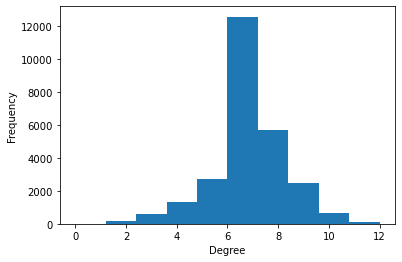

In [20]:
h1 = plt.hist(dict(nx.degree(G)).values(),10)
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [24]:
cc = []
for node in G.nodes:
    cc.append(nx.closeness_centrality(G,u=node))

KeyboardInterrupt: 